<a href="https://colab.research.google.com/github/FairozAhmadSheikh/DeepLearning_Bootcamp_with_Tensor_Flow/blob/main/Projects/102-Class%C2%A0Flower%C2%A0Classification%20with%20Transfer%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dealing with 100+ classes, especially when some are visually similar (like different flower species), requires a more powerful technique than a simple CNN built from scratch. We'll use the Oxford Flowers 102 dataset and implement Transfer Learning using a pre-trained model like MobileNetV2.**



In [19]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [20]:
#  Hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 102 # The Oxford Flowers 102 dataset has 102 classes
AUTOTUNE = tf.data.AUTOTUNE

In [22]:
# Load the Dataset
# Oxford Flowers 102 has 'train', 'validation', and 'test' splits
(train_ds_raw, val_ds_raw, test_ds_raw), metadata = tfds.load(
    'oxford_flowers102',
    split=['train', 'validation', 'test'],
    as_supervised=True,
    with_info=True,
)

print(f"Number of training examples: {metadata.splits['train'].num_examples}")
print(f"Number of classes: {metadata.features['label'].num_classes}")


Number of training examples: 1020
Number of classes: 102


In [23]:
#Preprocessing Function
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [24]:
# Augmentation Layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

In [25]:
# Create the Input Pipeline
def prepare_dataset(ds, shuffle=False, augment=False):
    ds = ds.map(preprocess, num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.batch(BATCH_SIZE)
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    return ds.cache().prefetch(AUTOTUNE)


In [26]:
# Prepare the final datasets
train_ds = prepare_dataset(train_ds_raw, shuffle=True, augment=True)
val_ds = prepare_dataset(val_ds_raw)
test_ds = prepare_dataset(test_ds_raw)

In [27]:
# Build Model using Keras Applications MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,  # remove classifier head
    weights='imagenet'  # use pretrained weights
)
base_model.trainable = False

# Functional API
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs, name="mobilenetv2_flowers")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [28]:
# --- Compile Model ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [29]:

model.summary()

Model: "mobilenetv2_flowers"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_8 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 102)            │        52,326 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,966,182 (11.32 MB)

 Trainable params: 708,198 (2.70 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [30]:
# Train Model
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 453ms/step - accuracy: 0.0373 - loss: 4.7506 - val_accuracy: 0.2000 - val_loss: 3.8807
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 108ms/step - accuracy: 0.2777 - loss: 3.4749 - val_accuracy: 0.4284 - val_loss: 2.9070
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.4372 - loss: 2.4711 - val_accuracy: 0.5363 - val_loss: 2.2127
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.5720 - loss: 1.8250 - val_accuracy: 0.6088 - val_loss: 1.8354
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.6716 - loss: 1.4103 - val_accuracy: 0.6500 - val_loss: 1.6142
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.7572 - loss: 1.0740 - val_accuracy: 0.6539 - val_loss: 1.4569
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.7945 - loss: 0.8929 - val_accuracy: 0.6725 - val_loss: 1.3536
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.8322 - loss: 0.7287 - val_accuracy: 

In [31]:
# Evaluate
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

193/193 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step - accuracy: 0.6778 - loss: 1.3117

Test Accuracy: 0.6723
Test Loss: 1.3062


Lets Fine Tune the Model

In [32]:
# Fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:  # unfreeze last 30 layers only
    layer.trainable = False

In [33]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [34]:
fine_tune_epochs = 5
total_epochs = EPOCHS + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1]
)


Epoch 10/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 180ms/step - accuracy: 0.3877 - loss: 2.5803 - val_accuracy: 0.7078 - val_loss: 1.1640
Epoch 11/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.4796 - loss: 2.0888 - val_accuracy: 0.6961 - val_loss: 1.1737
Epoch 12/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.5818 - loss: 1.6607 - val_accuracy: 0.6814 - val_loss: 1.1849
Epoch 13/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.6767 - loss: 1.3854 - val_accuracy: 0.6824 - val_loss: 1.1928
Epoch 14/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.7147 - loss: 1.1913 - val_accuracy: 0.6824 - val_loss: 1.1968
Epoch 15/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.7559 - loss: 1.0441 - val_accuracy: 0.6804 - val_loss: 1.2023


In [ ]:
# Evaluate after Fine-Tuning
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nFine-tuned Test Accuracy: {test_acc:.4f}")

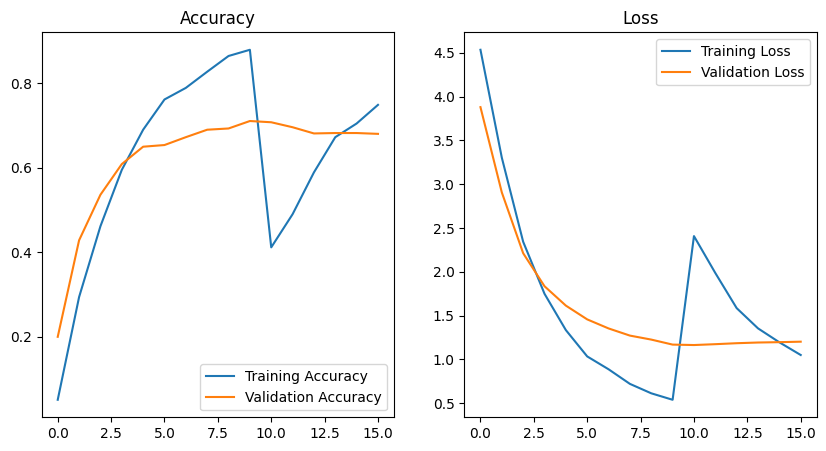

In [36]:
# Plot Training Curves
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()


In [ ]:
# Predict Some Samples
class_names = metadata.features['label'].names

for images, labels in test_ds.take(1):
    preds = model.predict(images)
    pred_labels = tf.argmax(preds, axis=1)
    plt.figure(figsize=(12, 12))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        true_label = class_names[labels[i].numpy()]
        pred_label = class_names[pred_labels[i].numpy()]
        color = "green" if true_label == pred_label else "red"
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis("off")
    plt.show()